In [2]:
# Imports
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Create output directory
out_dir = Path("notebooks/output/scenarios")
out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Load scenario statistics
stats_path = Path("../scenario_stats.json")
if not stats_path.exists():
    raise FileNotFoundError(f"Expected {stats_path} — run aggregate_scenario_stats.py first")

with open(stats_path, "r") as fh:
    scenario_stats = json.load(fh)

scenarios = list(scenario_stats.keys())
print(f"Loaded {len(scenarios)} scenarios: {scenarios}")

# Display success rates
for scenario in scenarios:
    stats = scenario_stats[scenario]
    print(f"\n{scenario}:")
    print(f"  Total runs: {stats['total_runs']:,}")
    print(f"  Successes: {stats['successes']:,}")
    print(f"  Success rate: {stats['success_rate']:.2%}")

Loaded 3 scenarios: ['baseline', 'both_features', 'playoff_seeding']

baseline:
  Total runs: 10,000
  Successes: 10,000
  Success rate: 100.00%

both_features:
  Total runs: 10,000
  Successes: 9,998
  Success rate: 99.98%

playoff_seeding:
  Total runs: 10,000
  Successes: 10,000
  Success rate: 100.00%


In [7]:
# Scotland opponent comparison across scenarios
team = "Scotland"

# Collect Scotland's opponents for each scenario
scotland_data = {}
for scenario in scenarios:
    teams_data = scenario_stats[scenario]["teams"]
    if team in teams_data:
        pair_pct = teams_data[team]["pair_pct"]
        scotland_data[scenario] = pair_pct
    else:
        print(f"Warning: {team} not found in {scenario}")
        scotland_data[scenario] = {}

# Build DataFrame: opponents as rows, scenarios as columns
all_opponents = set()
for pair_pct in scotland_data.values():
    all_opponents.update(pair_pct.keys())

scotland_df = pd.DataFrame(
    {
        scenario: {opp: scotland_data[scenario].get(opp, 0.0) for opp in all_opponents}
        for scenario in scenarios
    }
)

# Sort by baseline frequency
scotland_df = scotland_df.sort_values("baseline", ascending=False)

# Save to CSV
csv_path = out_dir / f"{team.replace(' ', '_')}_scenario_comparison.csv"
scotland_df.to_csv(csv_path)
print(f"Saved {csv_path}")

# Display top 48
print(f"\nTop 48 opponents for {team} (baseline scenario):")
print(scotland_df.head(48))

Saved notebooks/output/scenarios/Scotland_scenario_comparison.csv

Top 48 opponents for Scotland (baseline scenario):
                baseline  both_features  playoff_seeding
Inter Path 1       18.13       7.381476            13.21
Senegal            15.16      10.832166            13.58
Morocco            15.05      10.672134            13.66
Inter Path 2       14.01       0.000000             7.06
Cape Verde         13.79      13.922785            11.58
Ghana              13.66      14.142829            11.21
Japan              10.82      11.682336             9.90
South Korea        10.75      12.182436             9.91
Argentina          10.67      17.753551            10.31
Australia          10.52       0.000000             0.00
Brazil             10.20      17.693539            11.02
Jordan             10.02       8.541708             7.58
Iran                9.82      11.402280             9.54
Canada              9.46      21.784357            10.32
Mexico              9.07   

/tmp/ipykernel_1276/2985672536.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenario_opps_nonzero.values, y=scenario_opps_nonzero.index, palette="viridis")


Saved notebooks/output/scenarios/Scotland_opponents_baseline.png


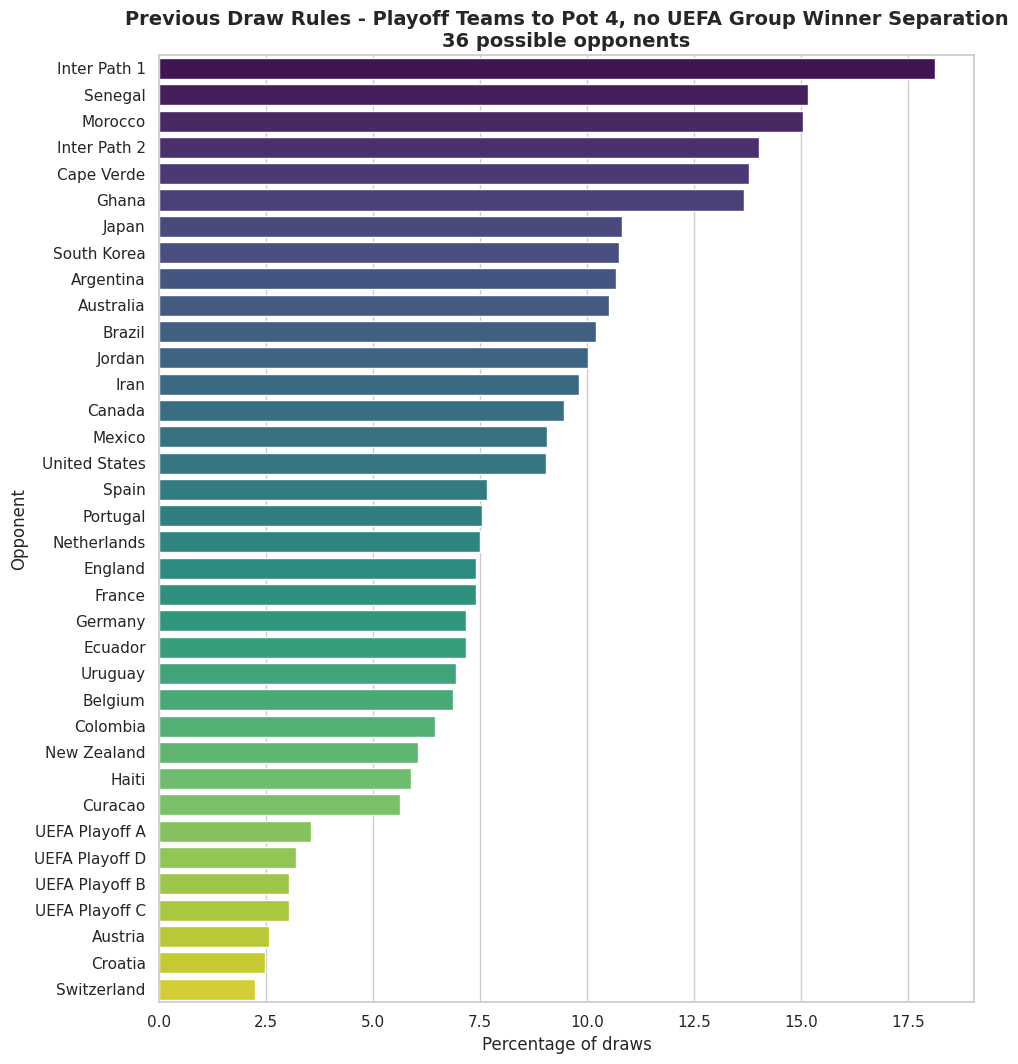


Previous Draw Rules - Playoff Teams to Pot 4, no UEFA Group Winner Separation:
  Total opponents: 36
  Top 5: Inter Path 1, Senegal, Morocco, Inter Path 2, Cape Verde



/tmp/ipykernel_1276/2985672536.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenario_opps_nonzero.values, y=scenario_opps_nonzero.index, palette="viridis")


Saved notebooks/output/scenarios/Scotland_opponents_both_features.png


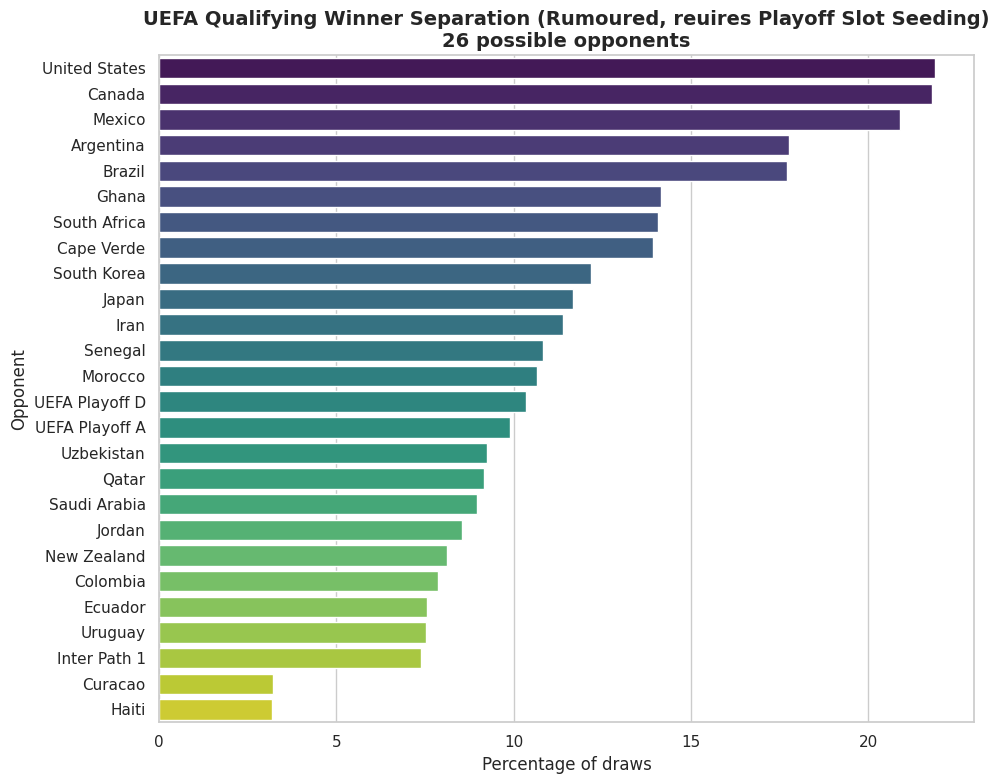


UEFA Qualifying Winner Separation (Rumoured, reuires Playoff Slot Seeding):
  Total opponents: 26
  Top 5: United States, Canada, Mexico, Argentina, Brazil



/tmp/ipykernel_1276/2985672536.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenario_opps_nonzero.values, y=scenario_opps_nonzero.index, palette="viridis")


Saved notebooks/output/scenarios/Scotland_opponents_playoff_seeding.png


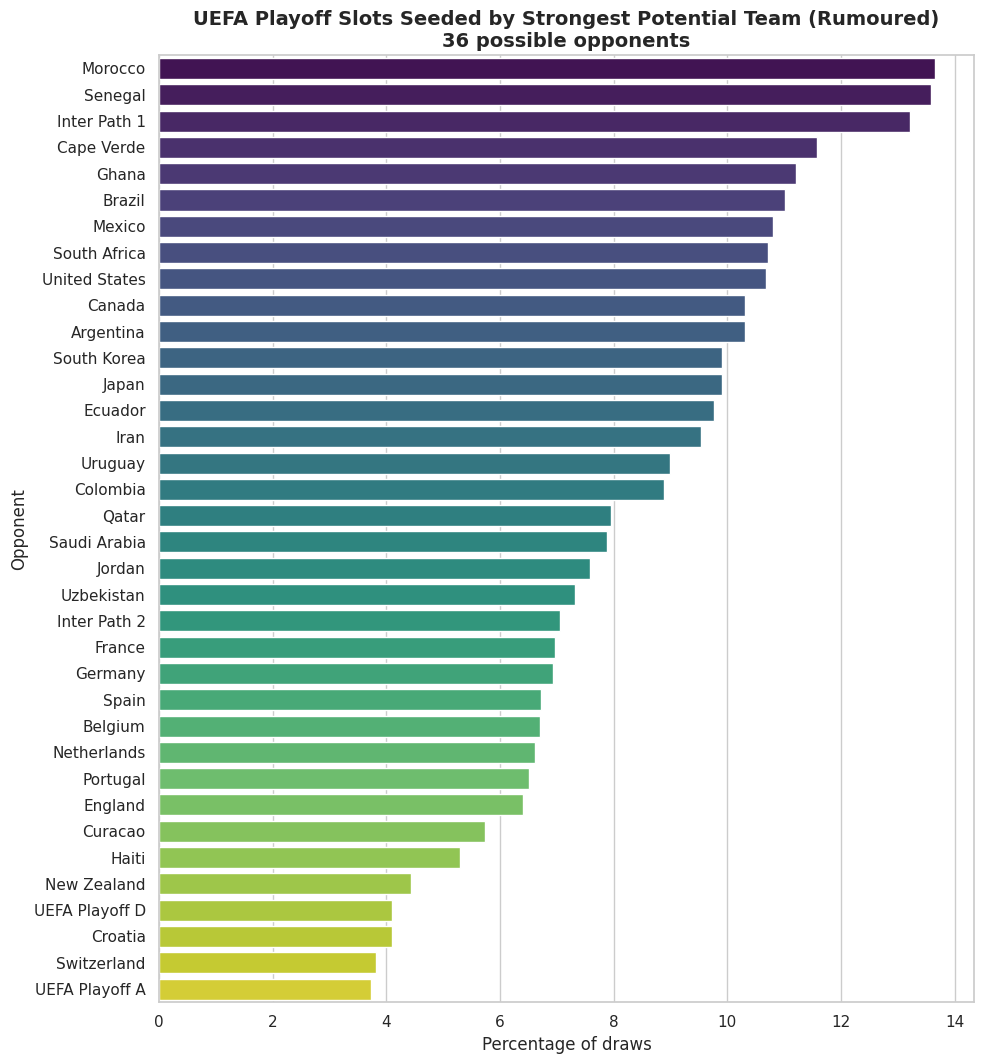


UEFA Playoff Slots Seeded by Strongest Potential Team (Rumoured):
  Total opponents: 36
  Top 5: Morocco, Senegal, Inter Path 1, Cape Verde, Ghana



In [18]:
# Plot Scotland opponents for each scenario separately (show all opponents up to 36)
scenario_names = {
    "baseline": "Previous Draw Rules - Playoff Teams to Pot 4, no UEFA Group Winner Separation",
    "playoff_seeding": "UEFA Playoff Slots Seeded by Strongest Potential Team (Rumoured)",
    "both_features": "UEFA Qualifying Winner Separation (Rumoured, reuires Playoff Slot Seeding)",
}

for scenario in scenarios:
    # Get Scotland's opponents for this scenario
    scenario_opps = scotland_df[scenario].sort_values(ascending=False)

    # Filter out zero values and limit to top 36
    scenario_opps_nonzero = scenario_opps[scenario_opps > 0].head(36)

    if scenario_opps_nonzero.empty:
        print(f"No opponents for {team} in {scenario}")
        continue

    # Create figure
    fig_height = max(8, 0.3 * len(scenario_opps_nonzero))
    plt.figure(figsize=(10, fig_height))

    # Create bar plot
    sns.barplot(x=scenario_opps_nonzero.values, y=scenario_opps_nonzero.index, palette="viridis")

    plt.xlabel("Percentage of draws", fontsize=12)
    plt.ylabel("Opponent", fontsize=12)
    plt.title(
        f"{scenario_names.get(scenario, scenario)}\n{len(scenario_opps_nonzero)} possible opponents",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()

    # Save figure
    img_path = out_dir / f"{team.replace(' ', '_')}_opponents_{scenario}.png"
    plt.savefig(img_path, dpi=150)
    print(f"Saved {img_path}")
    plt.show()

    # Print summary
    print(f"\n{scenario_names.get(scenario, scenario)}:")
    print(f"  Total opponents: {len(scenario_opps_nonzero)}")
    print(f"  Top 5: {', '.join(scenario_opps_nonzero.head(5).index.tolist())}")
    print()

Saved notebooks/output/scenarios/Scotland_group_distribution_scenarios.png


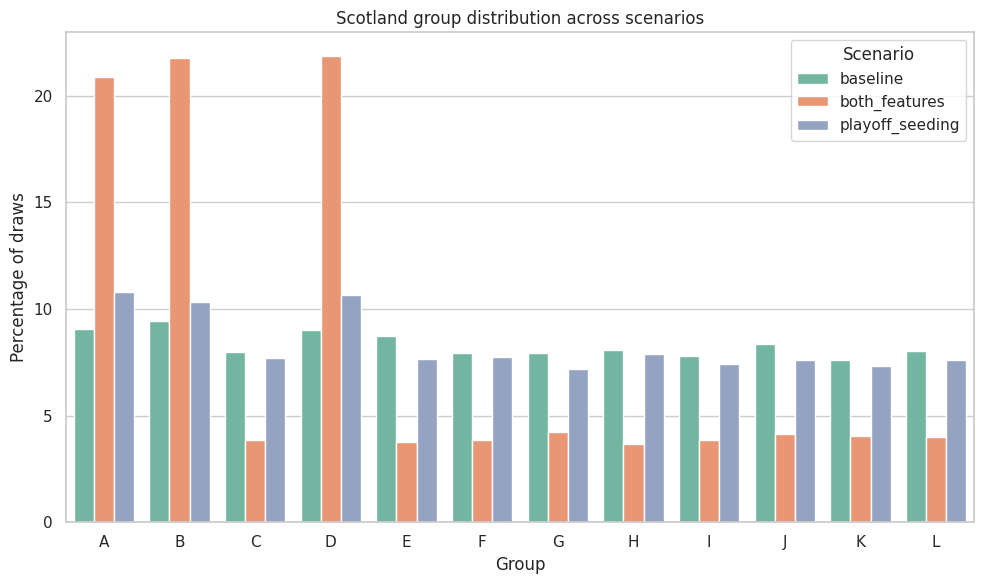

In [8]:
# Scotland group distribution comparison
group_data = {}
for scenario in scenarios:
    teams_data = scenario_stats[scenario]["teams"]
    if team in teams_data:
        group_pct = teams_data[team]["group_pct"]
        group_data[scenario] = group_pct
    else:
        group_data[scenario] = {}

# Build DataFrame: groups as rows, scenarios as columns
groups = [chr(ord("A") + i) for i in range(12)]
group_df = pd.DataFrame(
    {scenario: {g: group_data[scenario].get(g, 0.0) for g in groups} for scenario in scenarios}
)

# Reshape for plotting
group_df_melted = group_df.reset_index().melt(
    id_vars="index", var_name="scenario", value_name="percentage"
)
group_df_melted.rename(columns={"index": "group"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=group_df_melted, x="group", y="percentage", hue="scenario", palette="Set2")
plt.xlabel("Group")
plt.ylabel("Percentage of draws")
plt.title(f"{team} group distribution across scenarios")
plt.legend(title="Scenario")
plt.tight_layout()

img_path = out_dir / f"{team.replace(' ', '_')}_group_distribution_scenarios.png"
plt.savefig(img_path, dpi=150)
print(f"Saved {img_path}")
plt.show()


15 biggest changes in opponent probability (baseline vs both_features):
               baseline  both_features      delta
South Africa       0.00      14.082817  14.082817
Inter Path 2      14.01       0.000000 -14.010000
United States      9.03      21.884377  12.854377
Canada             9.46      21.784357  12.324357
Mexico             9.07      20.884177  11.814177
Inter Path 1      18.13       7.381476 -10.748524
Australia         10.52       0.000000 -10.520000
Uzbekistan         0.00       9.261852   9.261852
Qatar              0.00       9.171834   9.171834
Saudi Arabia       0.00       8.971794   8.971794
Spain              7.66       0.000000  -7.660000
Portugal           7.54       0.000000  -7.540000
Netherlands        7.50       0.000000  -7.500000
Brazil            10.20      17.693539   7.493539
England            7.41       0.000000  -7.410000

Saved notebooks/output/scenarios/Scotland_biggest_changes.csv


/tmp/ipykernel_1276/3609397255.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Saved notebooks/output/scenarios/Scotland_biggest_changes.png


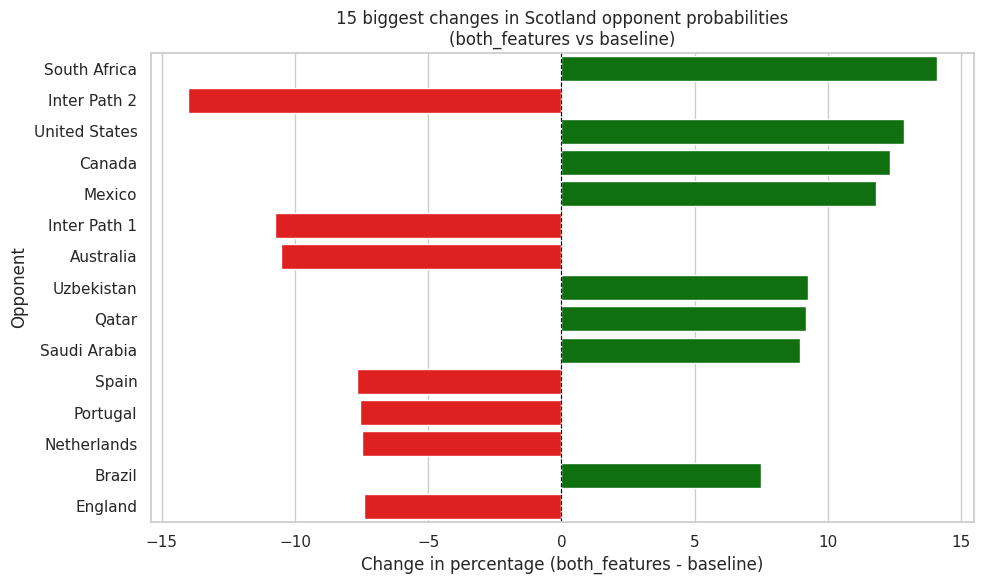

In [9]:
# Difference analysis: how much do probabilities change?
# Compare baseline vs both_features for Scotland's opponents
if "baseline" in scotland_df.columns and "both_features" in scotland_df.columns:
    scotland_df["delta"] = scotland_df["both_features"] - scotland_df["baseline"]
    scotland_df["abs_delta"] = scotland_df["delta"].abs()

    # Biggest changes (positive and negative)
    biggest_changes = scotland_df.nlargest(15, "abs_delta")[["baseline", "both_features", "delta"]]

    print("\n15 biggest changes in opponent probability (baseline vs both_features):")
    print(biggest_changes)

    # Save to CSV
    delta_path = out_dir / f"{team.replace(' ', '_')}_biggest_changes.csv"
    biggest_changes.to_csv(delta_path)
    print(f"\nSaved {delta_path}")

    # Plot the changes
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=biggest_changes["delta"].values,
        y=biggest_changes.index,
        palette=["red" if x < 0 else "green" for x in biggest_changes["delta"].values],
    )
    plt.xlabel("Change in percentage (both_features - baseline)")
    plt.ylabel("Opponent")
    plt.title(f"15 biggest changes in {team} opponent probabilities\n(both_features vs baseline)")
    plt.axvline(0, color="black", linestyle="--", linewidth=0.8)
    plt.tight_layout()

    img_path = out_dir / f"{team.replace(' ', '_')}_biggest_changes.png"
    plt.savefig(img_path, dpi=150)
    print(f"Saved {img_path}")
    plt.show()

In [10]:
# Summary statistics: how different are the scenarios?
if "baseline" in scotland_df.columns and "both_features" in scotland_df.columns:
    # Correlation between scenarios
    corr = scotland_df[["baseline", "playoff_seeding", "both_features"]].corr()
    print("\nCorrelation between scenarios (Scotland opponents):")
    print(corr)

    # Mean absolute difference
    mean_abs_diff_playoff = (scotland_df["baseline"] - scotland_df["playoff_seeding"]).abs().mean()
    mean_abs_diff_both = (scotland_df["baseline"] - scotland_df["both_features"]).abs().mean()

    print(f"\nMean absolute difference (baseline vs playoff_seeding): {mean_abs_diff_playoff:.3f}%")
    print(f"Mean absolute difference (baseline vs both_features): {mean_abs_diff_both:.3f}%")


Correlation between scenarios (Scotland opponents):
                 baseline  playoff_seeding  both_features
baseline         1.000000         0.588724       0.265232
playoff_seeding  0.588724         1.000000       0.669432
both_features    0.265232         0.669432       1.000000

Mean absolute difference (baseline vs playoff_seeding): 2.521%
Mean absolute difference (baseline vs both_features): 5.777%


## Key Findings

Summary of scenario comparison findings will be added here after running analysis.


Scotland host city probabilities:
               baseline  both_features  playoff_seeding
city                                                   
San Francisco     24.77          46.77            26.72
Seattle           24.44          46.86            26.39
Vancouver         24.44          46.86            26.39
Philadelphia      18.45           8.69            17.12
New York          18.21           8.71            17.07
Houston           18.07           8.66            17.14
Guadalajara       16.91          24.73            18.41
Dallas            16.23           8.00            15.34
Boston            15.84           7.80            15.16
Monterrey         15.02          23.77            16.61
Kansas City       14.61           6.91            13.42
Toronto           14.28           6.81            13.26
Atlanta           13.85           6.71            13.43
Miami             13.85           6.71            13.43
Los Angeles        5.95           3.19             5.39
Mexico City  

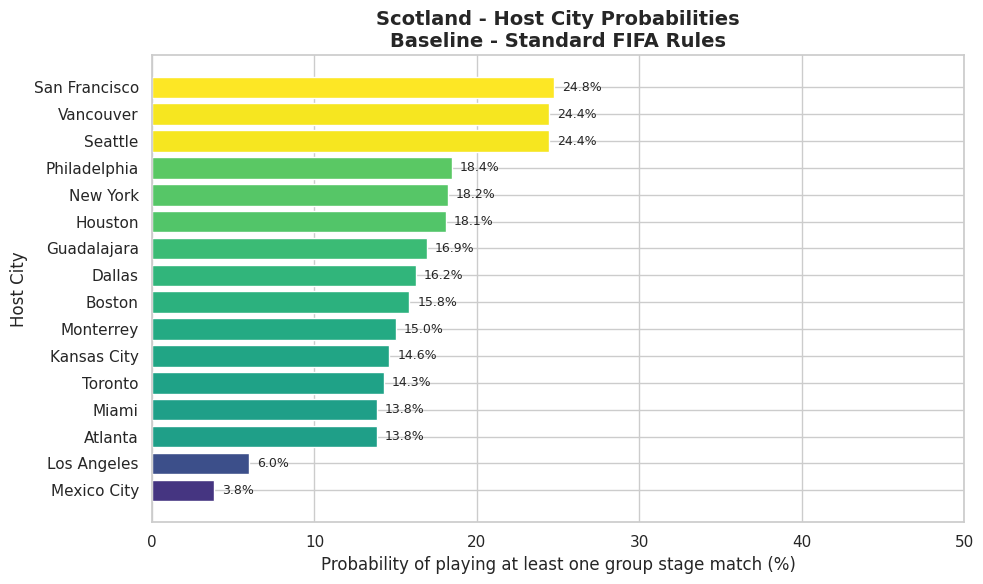


Saved notebooks/output/scenarios/Scotland_city_probabilities_playoff_seeding.png


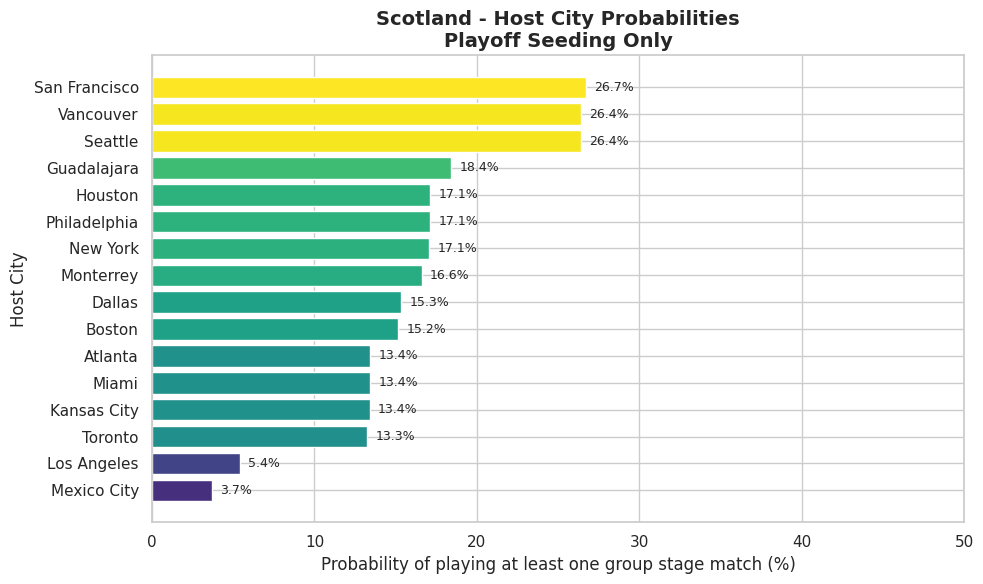


Saved notebooks/output/scenarios/Scotland_city_probabilities_both_features.png


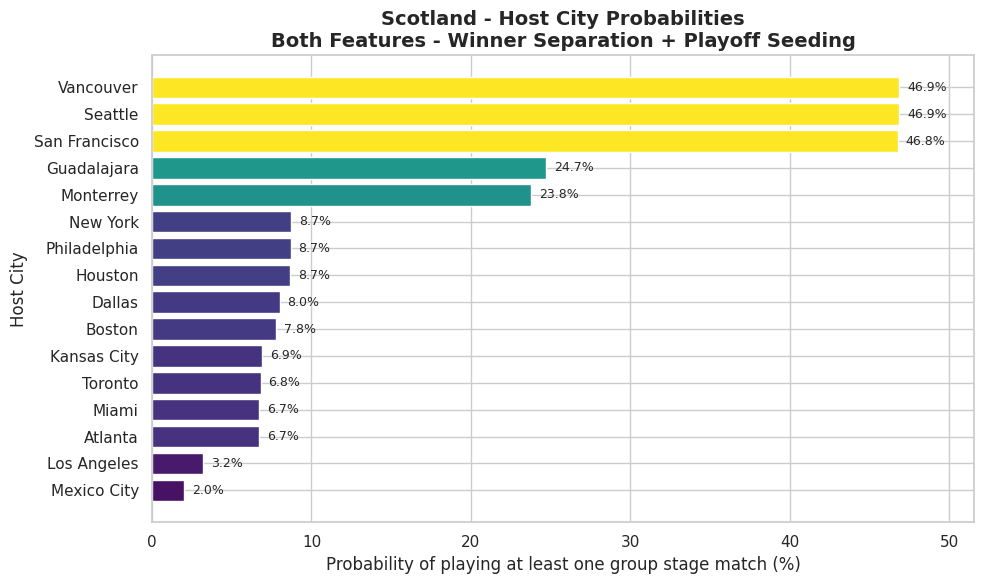


KEY INSIGHTS

Baseline - Most likely cities:
  San Francisco       :  24.8%
  Seattle             :  24.4%
  Vancouver           :  24.4%
  Philadelphia        :  18.4%
  New York            :  18.2%

Both features - Most likely cities:
  Seattle             :  46.9%
  Vancouver           :  46.9%
  San Francisco       :  46.8%
  Guadalajara         :  24.7%
  Monterrey           :  23.8%

UEFA Group Winners Separate:
  Seattle             : + 22.4% ( 24.4% →  46.9%)
  Vancouver           : + 22.4% ( 24.4% →  46.9%)
  San Francisco       : + 22.0% ( 24.8% →  46.8%)
  Monterrey           : +  8.8% ( 15.0% →  23.8%)
  Guadalajara         : +  7.8% ( 16.9% →  24.7%)


In [7]:
# Scotland host city probabilities across scenarios
team = "Scotland"

# Load city probability data
city_probs_path = Path("../scotland_city_probabilities_refined.csv")
if not city_probs_path.exists():
    print(f"Warning: {city_probs_path} not found. Run calculate_scotland_cities_refined.py first")
else:
    city_df = pd.read_csv(city_probs_path, index_col=0)

    # Pretty print city names
    def prettify_city(city_name):
        """Convert 'los-angeles' to 'Los Angeles'"""
        return city_name.replace("-", " ").title()

    city_df.index = city_df.index.map(prettify_city)

    print("\nScotland host city probabilities:")
    print(city_df.sort_values("baseline", ascending=False))

    # Scenario names for titles
    scenario_names = {
        "baseline": "Baseline - Standard FIFA Rules",
        "playoff_seeding": "Playoff Seeding Only",
        "both_features": "Both Features - Winner Separation + Playoff Seeding",
    }

    # Create separate chart for each scenario
    for scenario in ["baseline", "playoff_seeding", "both_features"]:
        if scenario not in city_df.columns:
            continue

        # Sort by this scenario's probabilities (descending - highest first)
        scenario_data = city_df[scenario].sort_values(
            ascending=True
        )  # ascending=True for barh to show highest at top

        # Create figure
        fig_height = max(6, 0.35 * len(scenario_data))
        plt.figure(figsize=(10, fig_height))

        # Create horizontal bar plot
        colors = plt.cm.viridis(scenario_data.values / scenario_data.max())
        plt.barh(range(len(scenario_data)), scenario_data.values, color=colors)
        plt.yticks(range(len(scenario_data)), scenario_data.index)
        plt.xlabel("Probability of playing at least one group stage match (%)", fontsize=12)
        plt.ylabel("Host City", fontsize=12)
        plt.title(
            f"{team} - Host City Probabilities\n{scenario_names.get(scenario, scenario)}",
            fontsize=14,
            fontweight="bold",
        )
        plt.xlim(0, max(scenario_data.max() * 1.1, 50))

        # Add percentage labels on bars
        for i, (city, prob) in enumerate(scenario_data.items()):
            plt.text(prob + 0.5, i, f"{prob:.1f}%", va="center", fontsize=9)

        plt.tight_layout()

        # Save figure
        img_path = out_dir / f"{team.replace(' ', '_')}_city_probabilities_{scenario}.png"
        plt.savefig(img_path, dpi=150)
        print(f"\nSaved {img_path}")
        plt.show()

    # Print key insights
    print(f"\n{'=' * 70}")
    print("KEY INSIGHTS")
    print(f"{'=' * 70}")

    print("\nBaseline - Most likely cities:")
    baseline_top = city_df.sort_values("baseline", ascending=False).head(5)
    for city, row in baseline_top.iterrows():
        print(f"  {city:20s}: {row['baseline']:5.1f}%")

    print("\nBoth features - Most likely cities:")
    both_top = city_df.sort_values("both_features", ascending=False).head(5)
    for city, row in both_top.iterrows():
        print(f"  {city:20s}: {row['both_features']:5.1f}%")

    # Calculate difference
    city_df["delta"] = city_df["both_features"] - city_df["baseline"]
    print("\nUEFA Group Winners Separate:")
    biggest_increase = city_df.sort_values("delta", ascending=False).head(5)
    for city, row in biggest_increase.iterrows():
        print(
            f"  {city:20s}: +{row['delta']:5.1f}% ({row['baseline']:5.1f}% → {row['both_features']:5.1f}%)"
        )


Mexico - Pot 2 Opponent Probabilities

All pot 2 opponents (baseline scenario):
             baseline  both_features  playoff_seeding
Ecuador         10.37       7.511502            10.22
Colombia        10.17       7.771554            10.23
South Korea      8.46       6.721344             7.82
Japan            8.06       6.201240             7.45
Iran             7.99       6.211242             7.61
Australia        7.92       4.680936             7.89
Switzerland      7.25      17.753551             7.82
Austria          7.09      22.444489            10.69
Croatia          6.87      17.433487             7.80

Saved notebooks/output/scenarios/Mexico_pot2_opponents_baseline.png

Saved notebooks/output/scenarios/Mexico_pot2_opponents_baseline.png


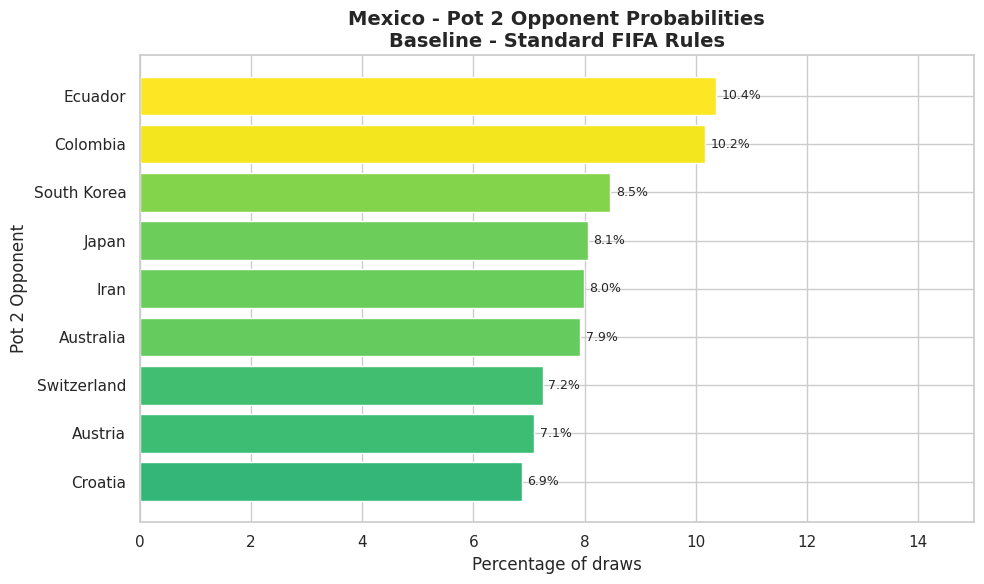


Saved notebooks/output/scenarios/Mexico_pot2_opponents_playoff_seeding.png


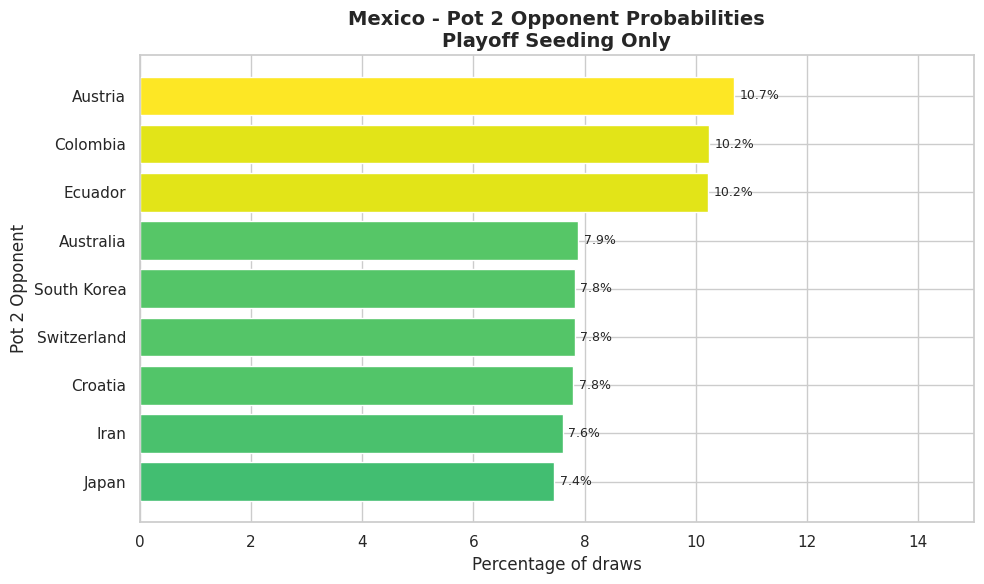


Saved notebooks/output/scenarios/Mexico_pot2_opponents_both_features.png


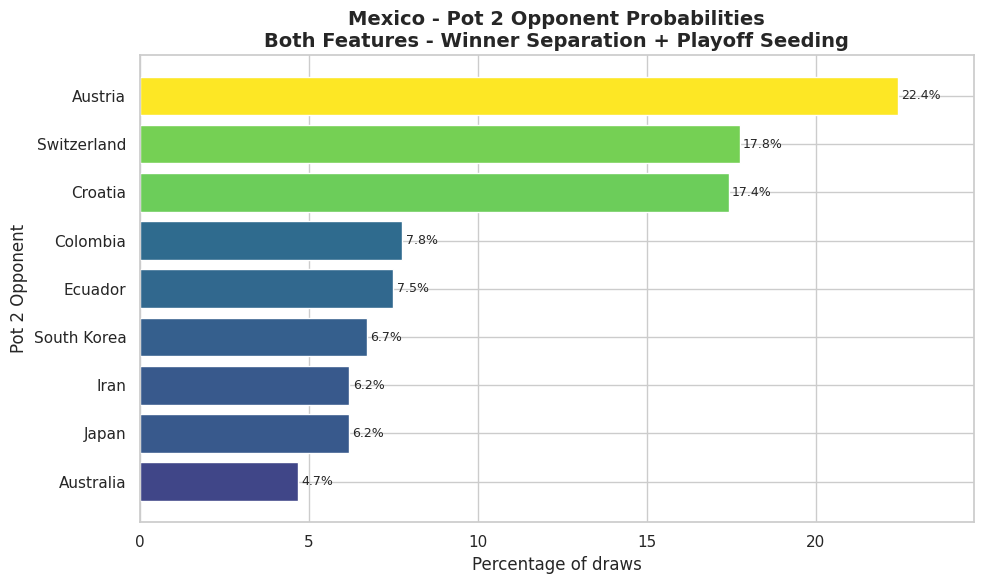


KEY INSIGHTS - Mexico Pot 2 Opponents

Baseline - Most likely pot 2 opponents:
  Ecuador             :  10.4%
  Colombia            :  10.2%
  South Korea         :   8.5%
  Japan               :   8.1%
  Iran                :   8.0%

Both features - Most likely pot 2 opponents:
  Austria             :  22.4%
  Switzerland         :  17.8%
  Croatia             :  17.4%
  Colombia            :   7.8%
  Ecuador             :   7.5%

Biggest changes (both_features vs baseline):
  Austria             : +15.4% (  7.1% →  22.4%)
  Croatia             : +10.6% (  6.9% →  17.4%)
  Switzerland         : +10.5% (  7.2% →  17.8%)
  South Korea         :  -1.7% (  8.5% →   6.7%)
  Iran                :  -1.8% (  8.0% →   6.2%)


In [ ]:
# Mexico pot 2 opponent probabilities across scenarios
team = "Mexico"

# Load scenario statistics if not already loaded
if "scenario_stats" not in globals():
    stats_path = Path("../scenario_stats.json")
    if not stats_path.exists():
        raise FileNotFoundError(f"Expected {stats_path} — run aggregate_scenario_stats.py first")

    with open(stats_path, "r") as fh:
        scenario_stats = json.load(fh)

    scenarios = list(scenario_stats.keys())

# Define pot 2 teams for each scenario
# Baseline: UEFA playoffs go to pot 4, so Austria and Australia are in pot 2
# Both features & Playoff seeding: UEFA playoffs are seeded, so Playoff A and D move to pot 2
pot2_by_scenario = {
    "baseline": [
        "Australia",
        "Austria",
        "Colombia",
        "Croatia",
        "Ecuador",
        "Iran",
        "Japan",
        "Morocco",
        "Senegal",
        "South Korea",
        "Switzerland",
        "Uruguay",
    ],
    "playoff_seeding": [
        "Colombia",
        "Croatia",
        "Ecuador",
        "Iran",
        "Japan",
        "Morocco",
        "Senegal",
        "South Korea",
        "Switzerland",
        "UEFA Playoff A",
        "UEFA Playoff D",
        "Uruguay",
    ],
    "both_features": [
        "Colombia",
        "Croatia",
        "Ecuador",
        "Iran",
        "Japan",
        "Morocco",
        "Senegal",
        "South Korea",
        "Switzerland",
        "UEFA Playoff A",
        "UEFA Playoff D",
        "Uruguay",
    ],
}

# Check if Mexico data exists
if team not in scenario_stats["baseline"]["teams"]:
    print(f"Warning: {team} not found in scenario data")
else:
    # Collect Mexico's pot 2 opponents for each scenario
    mexico_data = {}
    for scenario in scenarios:
        teams_data = scenario_stats[scenario]["teams"]
        if team in teams_data:
            pair_pct = teams_data[team]["pair_pct"]
            # Filter for pot 2 teams in this specific scenario
            pot2_teams = pot2_by_scenario[scenario]
            pot2_pair_pct = {opp: pct for opp, pct in pair_pct.items() if opp in pot2_teams}
            mexico_data[scenario] = pot2_pair_pct
        else:
            mexico_data[scenario] = {}

    # Build DataFrame: opponents as rows, scenarios as columns
    all_pot2_opponents = set()
    for pair_pct in mexico_data.values():
        all_pot2_opponents.update(pair_pct.keys())

    mexico_df = pd.DataFrame(
        {
            scenario: {opp: mexico_data[scenario].get(opp, 0.0) for opp in all_pot2_opponents}
            for scenario in scenarios
        }
    )

    mexico_df = mexico_df.sort_values("baseline", ascending=False)

    print(f"\n{team} - Pot 2 Opponent Probabilities")
    print(f"{'=' * 70}")
    print("\nAll pot 2 opponents (sorted by baseline probability):")
    print(mexico_df)

    # Scenario names for titles
    scenario_names = {
        "baseline": "Baseline - Standard FIFA Rules",
        "playoff_seeding": "Playoff Seeding Only",
        "both_features": "Both Features - Winner Separation + Playoff Seeding",
    }

    # Create separate chart for each scenario
    for scenario in ["baseline", "playoff_seeding", "both_features"]:
        if scenario not in mexico_df.columns:
            continue

        # Sort by this scenario's probabilities (show all pot 2 teams)
        scenario_data = mexico_df[scenario].sort_values(
            ascending=True
        )  # ascending=True for barh to show highest at top

        # Filter out zero values
        scenario_data = scenario_data[scenario_data > 0]

        if scenario_data.empty:
            print(f"\nNo pot 2 opponents for {team} in {scenario}")
            continue

        # Create figure
        fig_height = max(6, 0.35 * len(scenario_data))
        plt.figure(figsize=(10, fig_height))

        # Create horizontal bar plot
        colors = plt.cm.viridis(scenario_data.values / scenario_data.max())
        plt.barh(range(len(scenario_data)), scenario_data.values, color=colors)
        plt.yticks(range(len(scenario_data)), scenario_data.index)
        plt.xlabel("Percentage of draws", fontsize=12)
        plt.ylabel("Pot 2 Opponent", fontsize=12)
        plt.title(
            f"{team} - Pot 2 Opponent Probabilities\n{scenario_names.get(scenario, scenario)}",
            fontsize=14,
            fontweight="bold",
        )
        plt.xlim(0, max(scenario_data.max() * 1.1, 15))

        # Add percentage labels on bars
        for i, (opponent, prob) in enumerate(scenario_data.items()):
            plt.text(prob + 0.1, i, f"{prob:.1f}%", va="center", fontsize=9)

        plt.tight_layout()

        # Save figure
        img_path = out_dir / f"{team.replace(' ', '_')}_pot2_opponents_{scenario}.png"
        plt.savefig(img_path, dpi=150)
        print(f"\nSaved {img_path}")
        plt.show()

    # Print key insights
    print(f"\n{'=' * 70}")
    print(f"KEY INSIGHTS - {team} Pot 2 Opponents")
    print(f"{'=' * 70}")

    print("\nBaseline - Most likely pot 2 opponents:")
    baseline_top = mexico_df.sort_values("baseline", ascending=False).head(5)
    for opponent, row in baseline_top.iterrows():
        if row["baseline"] > 0:
            print(f"  {opponent:20s}: {row['baseline']:5.1f}%")

    print("\nBoth features - Most likely pot 2 opponents:")
    both_top = mexico_df.sort_values("both_features", ascending=False).head(5)
    for opponent, row in both_top.iterrows():
        if row["both_features"] > 0:
            print(f"  {opponent:20s}: {row['both_features']:5.1f}%")

    # Calculate difference
    mexico_df["delta"] = mexico_df["both_features"] - mexico_df["baseline"]
    print("\nBiggest changes (both_features vs baseline):")
    biggest_changes = mexico_df.sort_values("delta", ascending=False).head(5)
    for opponent, row in biggest_changes.iterrows():
        if abs(row["delta"]) > 0.01:  # Only show meaningful changes
            print(
                f"  {opponent:20s}: {row['delta']:+5.1f}% ({row['baseline']:5.1f}% → {row['both_features']:5.1f}%)"
            )